# This notebook will plot the distribution of V1 cell responses to natural images. The data is 2P calcium responses in the mouse brain, from the Allen Brain Observatory. 

In [35]:
#load data (V1, natural image responses) for a sample mouse
import os
import platform
import pandas as pd
import numpy as np
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info



#sets the drive path of hard-disk containing observatory data, based on current OS
if platform.system()=='Windows':
    drive_path = 'g:/'
else:
    drive_path = '/Volumes/Brain2016/'
    

manifest_path = os.path.join(drive_path, 'BrainObservatory/manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)

cre_lines = boc.get_all_cre_lines()
print("all cre lines:\n")
print(cre_lines)


all cre lines:

[u'Cux2-CreERT2', u'Emx1-IRES-Cre', u'Nr5a1-Cre', u'Rbp4-Cre', u'Rbp4-Cre_KL100', u'Rorb-IRES2-Cre', u'Scnn1a-Tg3-Cre']


In [36]:
# find all experiment containers that are from V1 and have natural gratings, and choose 1
rbp4_ecs = boc.get_experiment_containers(targeted_structures=['VISpm'],cre_lines=['Rbp4-Cre'])

container_id = rbp4_ecs[0]['id']
print len(rbp4_ecs)

exp = boc.get_ophys_experiments(experiment_container_ids=[container_id], 
                                stimuli=[stim_info.NATURAL_SCENES])[0]


print('Experiment container info:')
print exp



4
Experiment container info:
{'session_type': u'three_session_B', 'age_days': 80.0, 'imaging_depth': 375, 'experiment_container_id': 511511015, 'targeted_structure': u'VISpm', 'cre_line': u'Rbp4-Cre', 'id': 510706209}


In [37]:
# get the data
data_set = boc.get_ophys_experiment_data(exp['id'])
specimens=data_set.get_cell_specimen_ids()
timestamps, traces = data_set.get_dff_traces()


In [56]:
# stimulus info
# there are 118 (0-117) natural images. images were luminance matched, contrast-normalized, and resized.
# each image was presented for 250 ms, with no inter-image gray period
# each image was presented 50 times, in random order
# there was a blank sweep roughly once every 100 images. this is coded as a -1
# these 118*50=5900+59 images were split across three sessions

# pull out the stim info
stim_list=['natural_scenes_1','natural_scenes_2','natural_scenes_3']

stim_table = data_set.get_stimulus_table('natural_scenes')
#print stim_table

image_id = stim_table.frame; # this is the index of the image

#find the indices of each block
diff_start=np.diff(stim_table.start)
sort_index=np.argsort(diff_start)[::-1]
sorted_diff_start=diff_start[sort_index]
start1_ind=0
end1_ind=min(sort_index[0:2])
start2_ind=end1_ind+1
end2_ind = max(sort_index[0:2])
start3_ind=end2_ind+1
end3_ind=len(stim_table.start)-1

#if the duration of any of the above blocks is greater than 9 minutes (14483 frames), something went wrong
if (stim_table.end[end1_ind]-stim_table.start[start1_ind]>16300) or \
        (stim_table.end[end2_ind]-stim_table.start[start2_ind]>16300) or\
        (stim_table.end[end3_ind]-stim_table.start[start3_ind]>16300):
    raise ValueError('The start and end indices for one of the blocks is wrong!!')


reponses_1 = traces[:, stim_table.start[start1_ind]: stim_table.end[end1_ind]]
reponses_2 = traces[:, stim_table.start[start2_ind]: stim_table.end[end2_ind]]
reponses_3 = traces[:, stim_table.start[start3_ind]: stim_table.end[end3_ind]]

responses = np.concatenate((reponses_1, reponses_2, reponses_3), axis=1)


(60,)


In [57]:
# plot the response of a cell to each image (how to handle resposnes to repeated images)
from allensdk.brain_observatory.natural_scenes import NaturalScenes
ns = NaturalScenes(data_set)
print("done analyzing natural scenes")


done analyzing natural scenes


In [66]:
#The peak property of the analysis object is a Pandas DataFrame of computed response metrics.
# For natural scences this includes:
print ns.peak.head()

# or you can just print the values for a particular cell
specimen_id = specimens[0]
specimen_ids = data_set.get_cell_specimen_ids()
cell_loc = np.argwhere(specimen_ids==specimen_id)[0][0]

print ns.peak.loc[cell_loc].head()


  scene_ns response_reliability_ns peak_dff_ns     ptest_ns   p_run_ns  \
0       86                      32     8.57634   0.00539851  0.0103639   
1       28                      16     9.55525  1.63892e-12   0.989632   
2        8                      30     4.36427    0.0680315   0.223827   
3       17                       6     4.55452     0.914136   0.404494   
4       76                      28     4.69845     0.309795   0.588902   

  run_modulation_ns time_to_peak_ns duration_ns cell_specimen_id  
0           13.8598         0.29925     0.03325        517443037  
1           2.61532           0.399      0.8645        517442700  
2           6.04167          1.1305     0.03325        517443481  
3          -9.78684         0.96425     0.03325        517443309  
4           3.14021         0.89775      0.0665        517443492  
scene_ns                           86
response_reliability_ns            32
peak_dff_ns                   8.57634
ptest_ns                   0.00539851
p

In [67]:
# The response property of the stimulus-specific analysis objects is 3-D array organized with the following dimensions:
# 0: num. number of natural scene frames (118+blank)
# 1: num. cells + 1 (running speed)
# 2: 0=response mean, 1=response standard error of the mean, 2=number of signficant trials

print np.shape(ns.response)


(119, 61, 3)


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

2.91547601488 3.09395375558


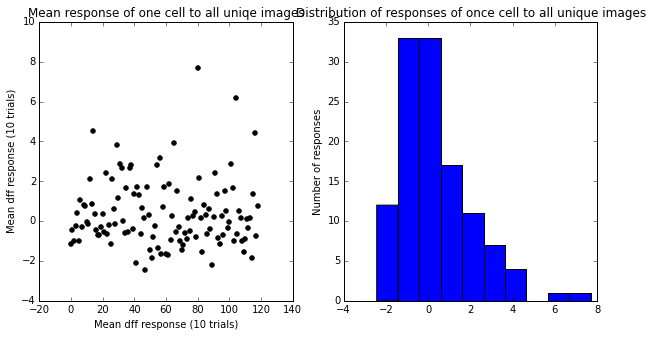

In [100]:
# plot the mean response of one cell to all images
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

cell_loc=30
mean_cell = np.squeeze(ns.response[:,cell_loc,0])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()

axs[0].scatter(np.arange(0,119,1), mean_cell, color='k')
axs[0].set_xlabel('Image index')
axs[0].set_ylabel('Mean dff response (10 trials)')
axs[0].set_title('Mean response of one cell to all uniqe images')

axs[1].hist(mean_cell)
axs[1].set_ylabel('Number of responses')
axs[0].set_xlabel('Mean dff response (10 trials)')
axs[1].set_title('Distribution of responses of once cell to all unique images')
plt.tick_params(axis='y', which='both', top='off')

#measure the kurtosis of the histogram
k1=stats.kurtosis(mean_cell, axis=0, fisher=True, bias=True)
k2=stats.kurtosis(mean_cell, axis=0, fisher=True, bias=False)
print k1,k2


In [82]:
# now caluclate the mean dff response yourself and make sure it's sort of similar
print(np.shape(responses))
trial_ind=0;
ind1=trial_ind*7
ind2=(trial_ind+1)*7
print ind1,ind2
np.mean(responses[0,ind1:ind2])

(60, 44769)
0 7


1.595623

7*118*50+50